# Курсовая работа

#### Применение вариационного автоэнкодера (VAE) для кодирования изображения и последующего восстановления с минимальными потерями качества

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
import cv2

from typing import List, Any
%matplotlib widget


Using TensorFlow backend.


## Preprocessing

In [2]:
os.chdir("/Users/akira/Documents/projects/polytech-study/computer_architecture/course_work")

data_dir = './data/pokemons/gen5'
output_dir = './output'

In [3]:
data_dirs = './data/pokemons/'
sub_dirs = [
    os.path.join(data_dirs, folder) 
    for folder in os.listdir(data_dirs) 
    if '.ipynb' not in folder and '.DS_Store' not in folder
]

filenames_paths = []
for sub_dir in sub_dirs:
    dir_paths = [
        os.path.join(sub_dir, file_name)
        for file_name in os.listdir(sub_dir)
        if '.png' in file_name
    ]
    filenames_paths.extend(dir_paths)

['./data/pokemons/gen4/566.png',
 './data/pokemons/gen4/572.png',
 './data/pokemons/gen4/573.png',
 './data/pokemons/gen4/567.png',
 './data/pokemons/gen4/559.png',
 './data/pokemons/gen4/571.png',
 './data/pokemons/gen4/565.png',
 './data/pokemons/gen4/564.png',
 './data/pokemons/gen4/570.png',
 './data/pokemons/gen4/558.png',
 './data/pokemons/gen4/574.png',
 './data/pokemons/gen4/560.png',
 './data/pokemons/gen4/561.png',
 './data/pokemons/gen4/575.png',
 './data/pokemons/gen4/563.png',
 './data/pokemons/gen4/577.png',
 './data/pokemons/gen4/576.png',
 './data/pokemons/gen4/562.png',
 './data/pokemons/gen4/459.png',
 './data/pokemons/gen4/471.png',
 './data/pokemons/gen4/465.png',
 './data/pokemons/gen4/539.png',
 './data/pokemons/gen4/505.png',
 './data/pokemons/gen4/511.png',
 './data/pokemons/gen4/510.png',
 './data/pokemons/gen4/504.png',
 './data/pokemons/gen4/538.png',
 './data/pokemons/gen4/464.png',
 './data/pokemons/gen4/470.png',
 './data/pokemons/gen4/458.png',
 './data/p

In [4]:
def crop_imgs(paths: List[str], x:int, y:int, width:int, height:int, color_type_changer=None) -> List[Any]:
    """
    Обрезка изображений в формат 64х64 пикселя
    
    paths - пути к изображениям
    x, y - начальные координаты коориднаты для обрезания
    width, height - конечные коориднаты для обрезания
    color_type_changer - при необходимости перекодировка каналов цвета
    
    return - изображения ввиде numpy.ndarray
    """
    imgs = []
    for f_path in paths:
        img = cv2.imread(f_path)
        if color_type_changer:
            img = cv2.cvtColor(img, color_type_changer)
        imgs.append(img[x:x+width, y:y+height])
    return imgs

In [5]:
imgs = crop_imgs(filenames_paths, 0, 0, 64, 64, cv2.COLOR_BGR2RGB)
imgs = np.array(imgs)
imgs.shape

(704, 64, 64, 3)

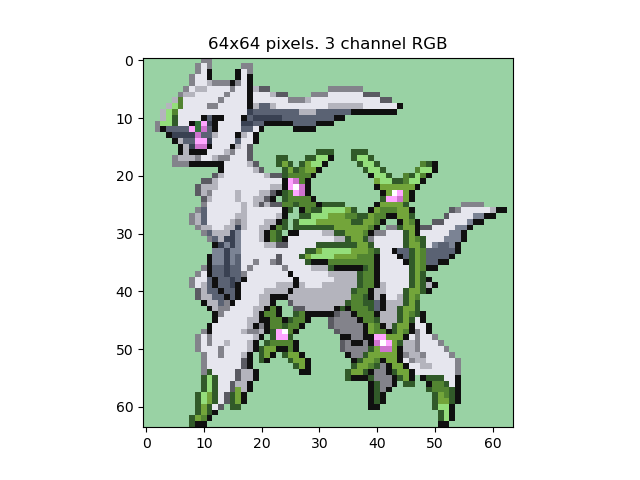

In [6]:
plt.imshow(imgs[1])
plt.title("64x64 pixels. 3 channel RGB")
plt.show()

In [7]:
def img_table(imgs: np.ndarray, path=None):
    """
    Создание таблицы из всех изображений с границей в 1 пиксел.
    RGB коды в формате 0-255
    
    imgs - массив изображений
    path: str - путь для сохранения картинки в формате png
    """
    img_h, img_w = imgs.shape[1:3]
    n_plots = int(np.ceil(np.sqrt(imgs.shape[0])))
    table = np.ones(
        (imgs.shape[1] * n_plots + n_plots + 1,
        imgs.shape[2] * n_plots + n_plots + 1,
        3))
    for i in range(n_plots):
        for j in range(n_plots):
            idx = i * n_plots + j
            if idx < imgs.shape[0]:
                img = imgs[idx]
                table[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = img
    table = table.astype(np.uint8)
    if path:
        plt.imsave(arr=table, fname=path)
    return table

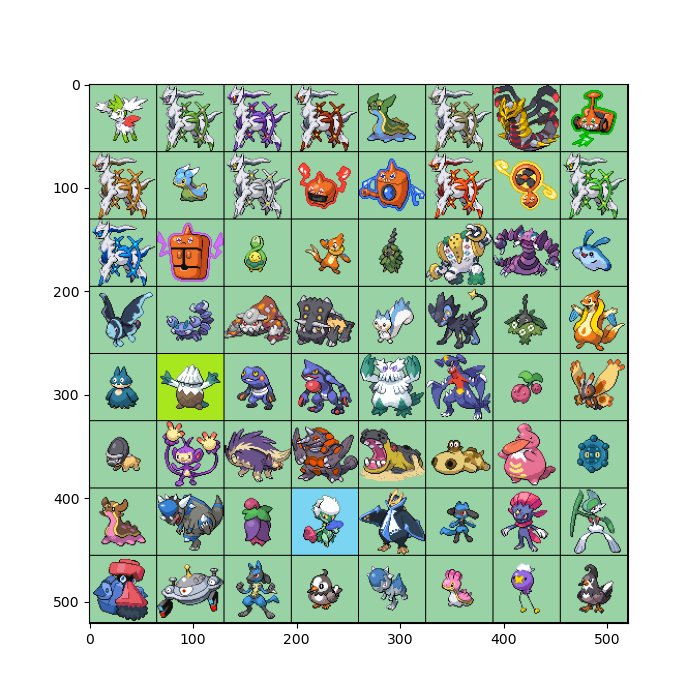

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img_table(imgs[:64]))
plt.show()

In [9]:
def normalization_0_1(imgs: np.ndarray) -> np.ndarray:
    """
    Нормализация кодов цветов от 0-255 к 0-1
    """
    return imgs.astype('float32') / 255.0 - 0.5

def normalization_0_255(imgs: np.ndarray) -> np.ndarray:
    """
    Нормализация кодов цветов от 0-1 к 0-255
    """
    return ((normal_imgs + 0.5) * 255).astype(np.uint8)

## Создание модели энкодера и декодера

In [10]:
normal_imgs = normalization_0_1(imgs)
X_train, X_test = train_test_split(normal_imgs, test_size=0.1, random_state=42)

In [11]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [12]:
# Same as (64,64,3), we neglect the number of instances from shape
IMG_SHAPE = normal_imgs.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 256)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256)               3145984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 64, 64, 3)         3158016   
Total params: 6,304,000
Trainable params: 6,304,000
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20,
                validation_data=[X_test, X_test])

Train on 633 samples, validate on 71 samples
Epoch 1/20
633/633 [==============================] - 3s 4ms/step - loss: 0.1060 - val_loss: 0.0539
Epoch 2/20
633/633 [==============================] - 2s 4ms/step - loss: 0.0503 - val_loss: 0.0431
Epoch 3/20
633/633 [==============================] - 2s 4ms/step - loss: 0.0418 - val_loss: 0.0399
Epoch 4/20
633/633 [==============================] - 3s 4ms/step - loss: 0.0383 - val_loss: 0.0381
Epoch 5/20
633/633 [==============================] - 3s 5ms/step - loss: 0.0366 - val_loss: 0.0370
Epoch 6/20
633/633 [==============================] - 3s 4ms/step - loss: 0.0355 - val_loss: 0.0361
Epoch 7/20
633/633 [==============================] - 2s 4ms/step - loss: 0.0346 - val_loss: 0.0353
Epoch 8/20
633/633 [==============================] - 3s 5ms/step - loss: 0.0339 - val_loss: 0.0347
Epoch 9/20
633/633 [==============================] - 3s 5ms/step - loss: 0.0332 - val_loss: 0.0342
Epoch 10/20
633/633 [==============================] - 

/Users/akira/opt/anaconda3/envs/ds-polytech/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/Users/akira/opt/anaconda3/envs/ds-polytech/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/akira/opt/anaconda3/envs/ds-polytech/lib/python3.7/site-packages/ipykernel_launcher.

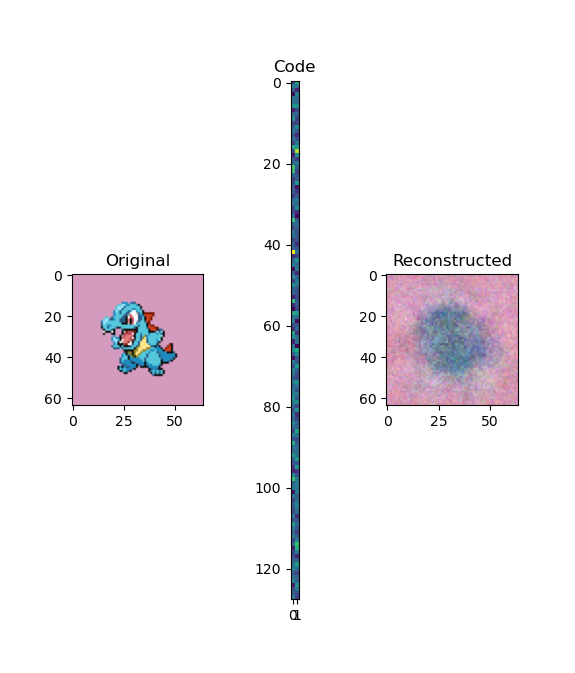

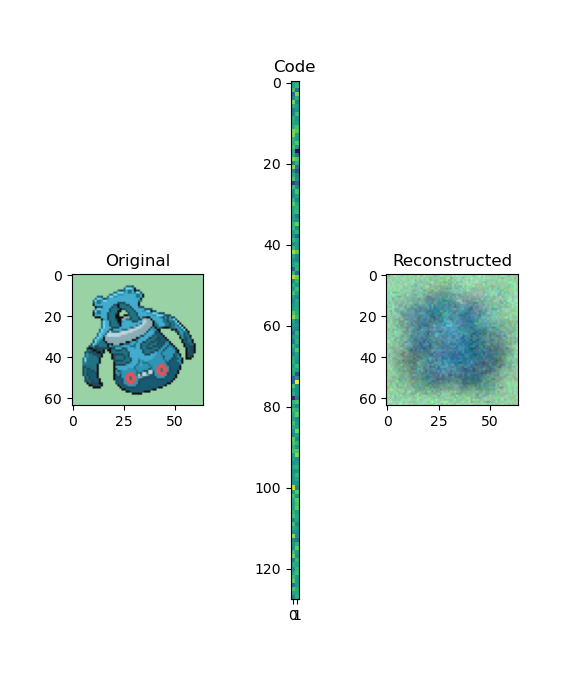

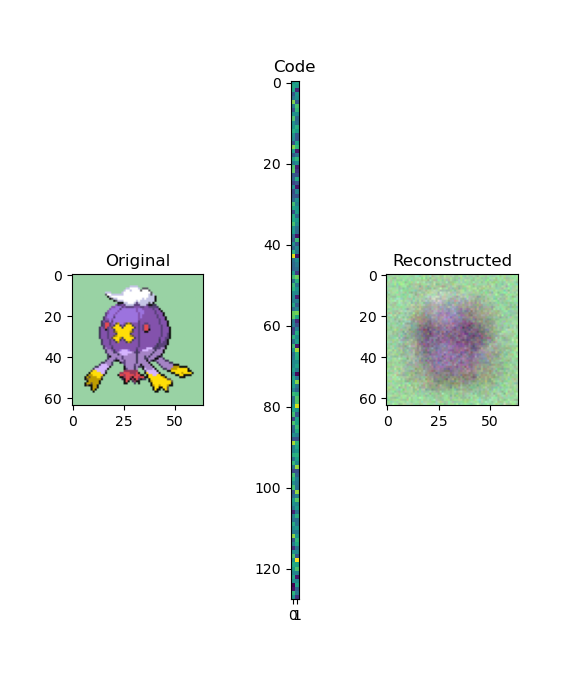

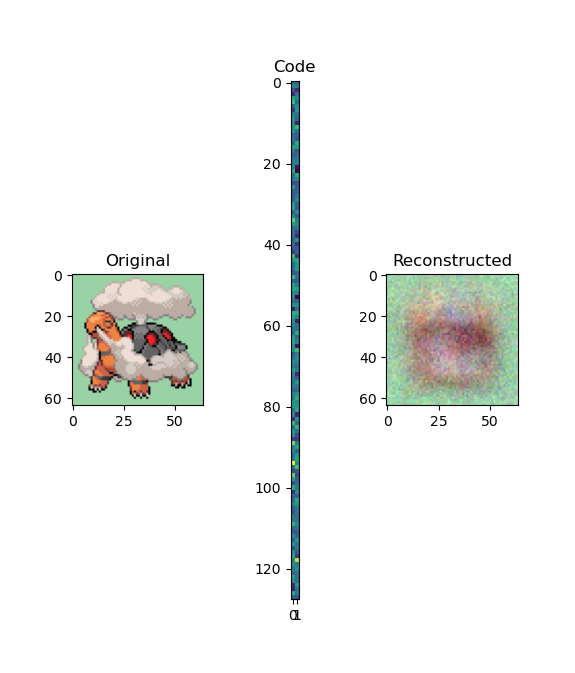

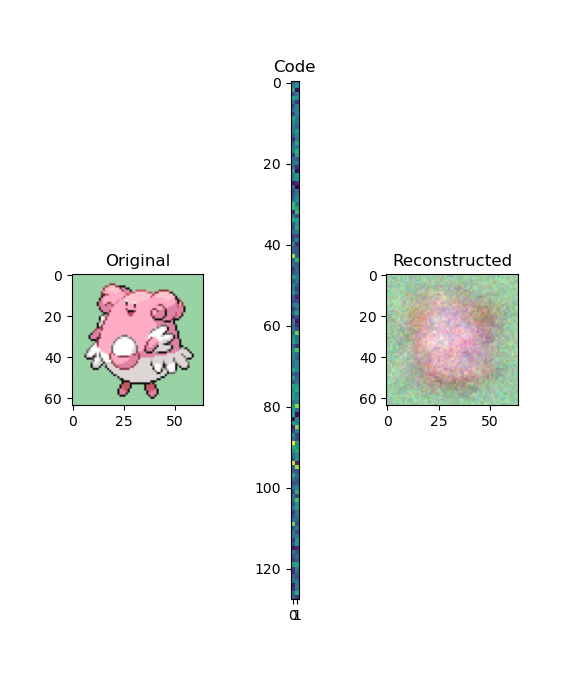

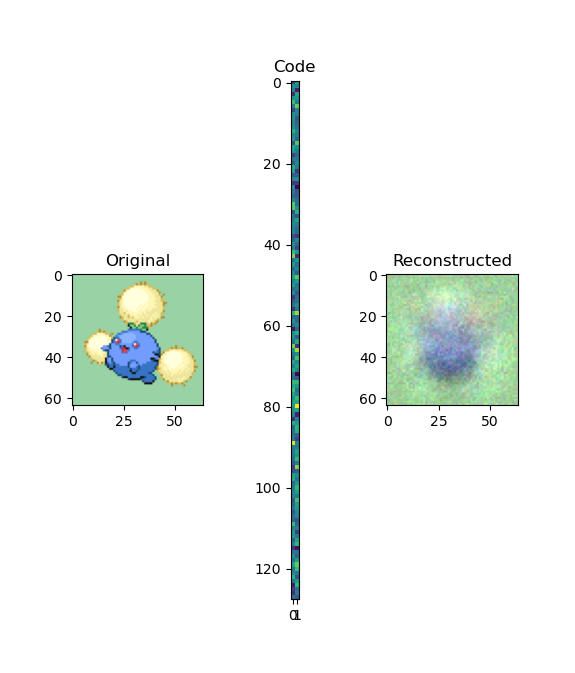

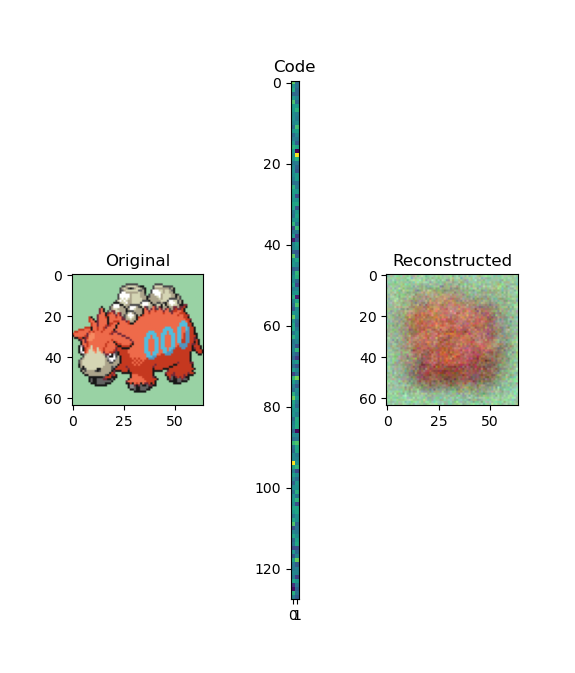

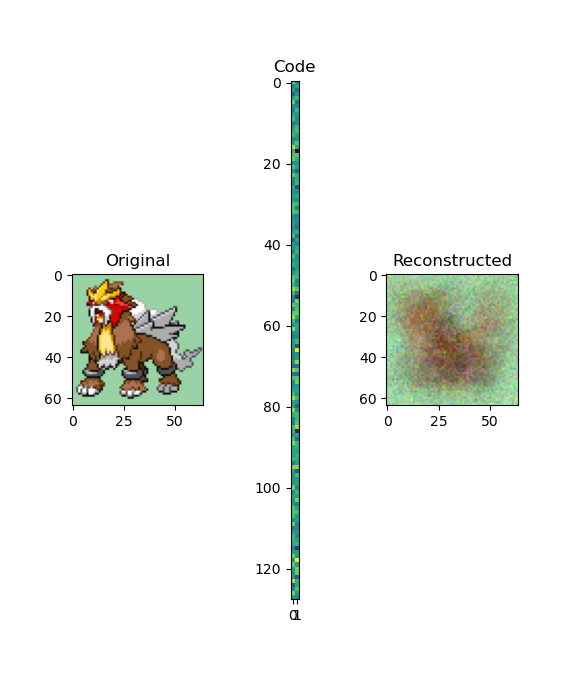

In [16]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))
    
    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(8):
    img = X_test[i]
    visualize(img,encoder,decoder)